# Data Analysis 3 - Assignment 2

In this project, it's aimed to determine a nightly price for its new apartments to a company operating in Florence / Italy, which can accommodate 2-6 people and rents small and medium-sized apartments. For this purpose, price and feature information of airbnb houses operating in Florence will be obtained from http://insideairbnb.com/get-the-data.html, Machine Learning price prediction models will be created and then these models will be compared with the models previously obtained for London.

### Sample Selection

First of all, data will be downloaded and cleaned for Exploratory Data Analysis (EDA) by applying filters we need.

In [970]:
#importing the packages

import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import os
from pathlib import Path
import sys
from patsy import dmatrices
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.impute import SimpleImputer
from sklearn.inspection import permutation_importance
from sklearn.inspection import PartialDependenceDisplay
from sklearn.inspection import partial_dependence
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_squared_error

## Downloading and Cleaning the Data

In [971]:
# importing helper functions
from py_helper_functions import *

In [972]:
# importing the data from Github for Florence
data = pd.read_csv('https://raw.githubusercontent.com/ab-dum/DA3/main/Assignment2/florence_listings.csv')



In [973]:
# checking the data how it looks like
data.head()

,id,listing_url,scrape_id,last_scraped,source,name,description,neighborhood_overview,picture_url,host_id,...,review_scores_communication,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,31840,https://www.airbnb.com/rooms/31840,20231218165100,2023-12-19,city scrape,Serviced apartment in Florence · ★4.65 · 1 bed...,NaN,NaN,https://a0.muscache.com/pictures/prohost-api/H...,380378,...,4.91,4.91,4.70,NaN,t,29,20,9,0,0.78
1,222527,https://www.airbnb.com/rooms/222527,20231218165100,2023-12-18,city scrape,Rental unit in Sesto Fiorentino · ★4.85 · 1 be...,NaN,NaN,https://a0.muscache.com/pictures/7882444/afb8d...,804468,...,4.96,4.60,4.86,NaN,f,2,2,0,0,1.92
2,32120,https://www.airbnb.com/rooms/32120,20231218165100,2023-12-18,city scrape,Rental unit in Florence · ★4.88 · 1 bedroom · ...,NaN,NaN,https://a0.muscache.com/pictures/miso/Hosting-...,99235,...,4.96,4.63,4.63,NaN,f,1,1,0,0,0.16
3,224562,https://www.airbnb.com/rooms/224562,20231218165100,2023-12-19,city scrape,Condo in Florence · ★4.66 · 1 bedroom · 1 bed ...,NaN,A due passi dall'Appartamento Stella si trova ...,https://a0.muscache.com/pictures/prohost-api/H...,1168814,...,4.83,4.93,4.64,048017LTN2402,f,1,1,0,0,0.71
4,32180,https://www.airbnb.com/rooms/32180,20231218165100,2023-12-19,city scrape,Condo in Florence · ★4.76 · 2 bedrooms · 4 bed...,NaN,NaN,https://a0.muscache.com/pictures/bcb23395-7215...,13925330,...,4.71,4.81,4.84,NaN,f,1,1,0,0,0.21


In [974]:
# there are 12578 rows and 75 columns
data.shape

(12578, 75)

### Exploratory Data Analysis (EDA)

First off all, we need to deal with extreme and missing values. Hence ıt makes sense to check the null values for each column

In [975]:
# checking the columns, types and non-null counts
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12578 entries, 0 to 12577
Data columns (total 75 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   id                                            12578 non-null  int64  
 1   listing_url                                   12578 non-null  object 
 2   scrape_id                                     12578 non-null  int64  
 3   last_scraped                                  12578 non-null  object 
 4   source                                        12578 non-null  object 
 5   name                                          12578 non-null  object 
 6   description                                   0 non-null      float64
 7   neighborhood_overview                         7383 non-null   object 
 8   picture_url                                   12578 non-null  object 
 9   host_id                                       12578 non-null 

- It is seen that some of the 75 columns have a high rate of missing values. In order to make more effective predictions, these values need to be cleaned or transformed.

In [976]:
# creating a function to find the percentange of null values for each column
def null_percentage(df):
    # finding the NA values in each column
    null_counts = df.isna().sum()
    
    # excluding the columns with zero NA values
    non_zero_na_columns = null_counts[null_counts > 0].index
    null_counts = null_counts[non_zero_na_columns]

    # calculating the percentage of NAs in each column
    na_percentage = (null_counts / len(df)) * 100

    # creating a DataFrame to display results
    result_df = pd.DataFrame({
        'Column': null_counts.index,
        'NA Count': null_counts.values,
        'NA Percentage': na_percentage.values
    })

    return result_df

result = null_percentage(data)
print(result)


                          Column  NA Count  NA Percentage
0                    description     12578     100.000000
1          neighborhood_overview      5195      41.302274
2                  host_location      2436      19.367149
3                     host_about      5128      40.769598
4             host_response_time      1882      14.962633
5             host_response_rate      1882      14.962633
6           host_acceptance_rate      1245       9.898235
7              host_is_superhost        53       0.421371
8             host_neighbourhood      5120      40.705995
9                  neighbourhood      5195      41.302274
10  neighbourhood_group_cleansed     12578     100.000000
11                     bathrooms     12578     100.000000
12                bathrooms_text         3       0.023851
13                      bedrooms     12567      99.912546
14                          beds       110       0.874543
15                         price      1087       8.642073
16            

In [977]:
# calculating the percentage of missing values in each column
missing_percentage = (data.isna().sum() / len(data)) * 100

In [978]:
# identifying the columns with more than 70% missing values
columns_to_drop = missing_percentage[missing_percentage > 70].index

In [979]:
# dropping the columns with more than 70% missing values
data = data.drop(columns=columns_to_drop)

In [980]:
# the number of columns decreased to 69
data.shape

(12578, 69)

In [981]:
# removing the rows with any NA values
data = data.dropna()

In [982]:
data.shape

(2683, 69)

In [983]:
# we have 2.683 rows and 69 columns without any NAs
data.isna().sum().sum()

0

- It is clear that there are other techniques than dropping when evaluating rows with NA values, and care should be taken when making this choice. If NA values represent any pattern, it may not make sense to drop them, but since it is known that there is no such pattern in this data set, the drop method was chosen.

In [984]:
# we need to filter data on number of accommodates that can accommodate on a listing
data.accommodates.unique()

array([ 4,  2,  1,  3,  5,  6, 10,  9,  7,  8, 11, 12, 14, 16, 15, 13])

In [985]:
# we need to focus on apartments that can host 2-6 guests
data = data[(data['accommodates'] >= 2) & (data['accommodates'] <= 6)]

In [986]:
# there are 2428 rows after filtering on number of 'accommodates'
data.shape

(2428, 69)

In [987]:
# showing the statistics for numeric variables in DataFrame
data.describe().T

,count,mean,std,min,25%,50%,75%,max
id,2428.0,1.052271e+17,2.736894e+17,3.911500e+04,8.281333e+06,2.216014e+07,3.886268e+07,1.035389e+18
scrape_id,2428.0,2.023122e+13,0.000000e+00,2.023122e+13,2.023122e+13,2.023122e+13,2.023122e+13,2.023122e+13
host_id,2428.0,5.452045e+07,6.925702e+07,3.321000e+04,5.856565e+06,2.432163e+07,7.655638e+07,3.259138e+08
host_listings_count,2428.0,3.976936e+01,1.034751e+02,1.000000e+00,2.000000e+00,5.000000e+00,1.900000e+01,4.870000e+02
host_total_listings_count,2428.0,5.518616e+01,1.457494e+02,1.000000e+00,2.000000e+00,6.000000e+00,2.600000e+01,7.040000e+02
latitude,2428.0,4.377297e+01,8.552385e-03,4.372607e+01,4.376839e+01,4.377173e+01,4.377638e+01,4.382511e+01
longitude,2428.0,1.125429e+01,1.340070e-02,1.116007e+01,1.124683e+01,1.125438e+01,1.126039e+01,1.132559e+01
accommodates,2428.0,3.588138e+00,1.344638e+00,2.000000e+00,2.000000e+00,4.000000e+00,4.000000e+00,6.000000e+00
beds,2428.0,2.097611e+00,1.091199e+00,1.000000e+00,1.000000e+00,2.000000e+00,3.000000e+00,8.000000e+00
minimum_nights,2428.0,4.180395e+00,3.527156e+01,1.000000e+00,2.000000e+00,2.000000e+00,3.000000e+00,1.125000e+03


In [988]:
# checking the price column
data.price.unique()

array(['$60.00', '$86.00', '$83.00', '$61.00', '$95.00', '$159.00',
       '$82.00', '$65.00', '$90.00', '$66.00', '$120.00', '$106.00',
       '$130.00', '$126.00', '$279.00', '$85.00', '$129.00', '$113.00',
       '$114.00', '$124.00', '$161.00', '$81.00', '$257.00', '$137.00',
       '$179.00', '$88.00', '$93.00', '$231.00', '$51.00', '$140.00',
       '$176.00', '$184.00', '$154.00', '$214.00', '$63.00', '$213.00',
       '$119.00', '$76.00', '$100.00', '$186.00', '$150.00', '$162.00',
       '$146.00', '$180.00', '$69.00', '$181.00', '$50.00', '$110.00',
       '$286.00', '$72.00', '$67.00', '$80.00', '$92.00', '$59.00',
       '$75.00', '$78.00', '$128.00', '$200.00', '$109.00', '$99.00',
       '$56.00', '$91.00', '$450.00', '$131.00', '$241.00', '$44.00',
       '$141.00', '$350.00', '$225.00', '$122.00', '$152.00', '$73.00',
       '$132.00', '$171.00', '$160.00', '$117.00', '$84.00', '$173.00',
       '$372.00', '$54.00', '$55.00', '$116.00', '$134.00', '$139.00',
       '$40

In [989]:
# price column is the our target column to predict but it is not numeric and includes $ sign and commas
# removing dollar sign and commas, then converting to float
data['price'] = data['price'].replace('[\$,]', '', regex=True).astype(float)
data.price.describe(percentiles = [0.01, 0.1, 0.25, 0.5, 0.75, 0.9, 0.99]).map('{:,.1f}'.format)

count    2,428.0
mean       149.9
std        219.8
min         17.0
1%          38.0
10%         60.0
25%         81.0
50%        111.0
75%        163.0
90%        258.0
99%        616.1
max      8,023.0
Name: price, dtype: object

- It can be seen that the minimum (17) and maximum (8,023) price range is quite wide. Additionally, the mean is 149 while the median is 111.

In [990]:
# changing the datatype of the rate columns from object to float and removing '%' sign
data['host_response_rate'] = data['host_response_rate'].str.rstrip('%').astype(float)
data['host_acceptance_rate'] = data['host_acceptance_rate'].str.rstrip('%').astype(float)

In [991]:
# checking the value counts of 'number of reviews' column
data.number_of_reviews.value_counts().sort_index()

number_of_reviews
1      64
2      50
3      38
4      32
5      41
       ..
776     1
788     1
818     1
841     1
890     1
Name: count, Length: 469, dtype: int64

### Categorical Variables

In [992]:
# 'amenities' has empty list so we will not be able to use this column
data.amenities.unique()

array(['[]'], dtype=object)

In [993]:
# checking the value counts of 'room_type' column
data.room_type.value_counts()

room_type
Entire home/apt    2110
Private room        285
Hotel room           33
Name: count, dtype: int64

In [994]:
# since we need to focus on 'apartments', the rows where `room_type` column has 'Hotel room' were dropped
data = data[data['room_type'] != 'Hotel room']

In [995]:
# checking the value counts of 'property_type' column
data.property_type.value_counts()

property_type
Entire rental unit                    1430
Entire condo                           438
Private room in rental unit            143
Entire loft                            119
Entire home                             54
Private room in bed and breakfast       35
Private room in condo                   34
Entire vacation home                    24
Entire serviced apartment               22
Private room in home                    22
Entire townhouse                         9
Private room                             8
Private room in serviced apartment       7
Entire villa                             6
Room in boutique hotel                   6
Private room in loft                     5
Tiny home                                5
Private room in villa                    5
Private room in guesthouse               4
Private room in townhouse                4
Room in aparthotel                       4
Private room in casa particular          4
Entire cottage                          

In [996]:
# removing the rows where `property_type` column contains words 'hotel' or 'hostel'.
data = data[~data['property_type'].str.contains('hotel|hostel', case=False)]

- Since there are too many property types and most of them have only few observations,it makes sense to drop property types that have less 10 observations

In [997]:
# counting the occurrences of each property type
property_counts = data['property_type'].value_counts()

# filtering out property types with less than 10 occurrences
property_types_to_keep = property_counts[property_counts >= 10].index

# filtering the DataFrame to keep only rows with property types that have at least 10 occurrences
data = data[data['property_type'].isin(property_types_to_keep)]

In [998]:
# checking the unique districts in Florence
data.neighbourhood_cleansed.value_counts()

neighbourhood_cleansed
Centro Storico       1906
Campo di Marte        172
Rifredi               118
Isolotto Legnaia       63
Gavinana Galluzzo      62
Name: count, dtype: int64

- Since 'bathrooms' column is empty we need to focus on 'bathrooms_text' column because of the fact that its a potential explanatory variable

In [999]:
data.bathrooms_text.unique()

array(['1 bath', '0 baths', '1 private bath', '2 baths', '1.5 baths',
       '3 baths', '2 shared baths', '3.5 baths', '1 shared bath',
       '2.5 baths', '4 baths', '1.5 shared baths', '3 shared baths',
       '4.5 baths'], dtype=object)

In [1000]:
# converting the string values to numeric values by using a mapping dictionary
mapping = {
    '1 bath' :1,
    '0 baths' :0,
    '1 private bath':1,
    '2 baths':2,
    '1.5 baths':1.5,
    '3 baths':3,
    '2 shared baths':2,
    '3.5 baths':3.5,
    '1 shared bath':1,
    '2.5 baths':2.5, 
    '4 baths':4,
    '1.5 shared baths':2.5, 
    '3 shared baths':3,
    '4.5 baths':4.5
    
}
    


# mapping the new values to a new column 'n_bathrooms'
data['n_bathrooms'] = data['bathrooms_text'].map(mapping)

In [1001]:
# checking the datatypes of 'host_is_superhost' column (f and t)
data.host_is_superhost.values

array(['f', 't', 'f', ..., 't', 't', 't'], dtype=object)

In [1002]:
# converting the 'host_is_superhost' to a dummy variable 
data['host_is_superhost'] = data['host_is_superhost'].replace({'t': 1, 'f': 0})
data.host_is_superhost.unique()

array([0, 1])

### Checking the Extreme Values

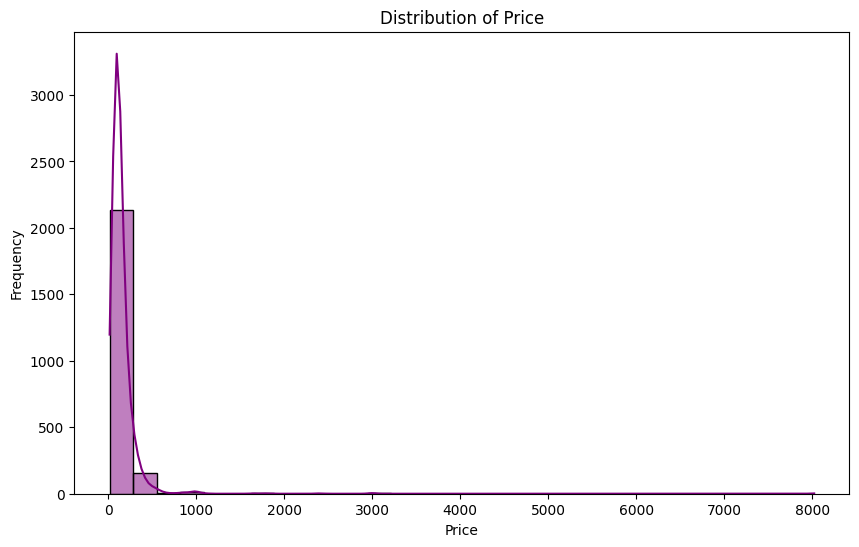

In [1003]:
import matplotlib.pyplot as plt
import seaborn as sns

# showing the distribution of 'price' column
plt.figure(figsize=(10, 6))
sns.histplot(data['price'], kde=True, color='purple', bins=30)
plt.title('Distribution of Price')
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.show()


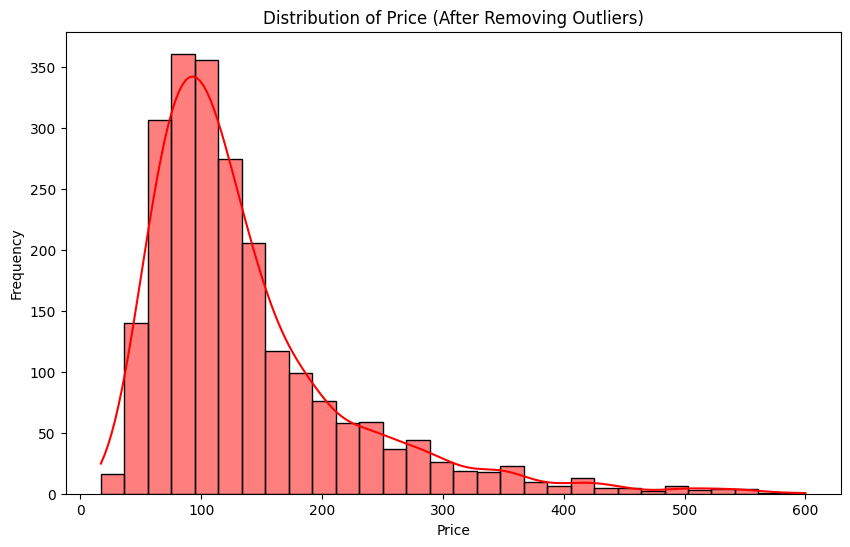

In [1004]:
# defining threshold for outliers 
x = data['price'].quantile(0.99)

# Remove outliers
data = data[data['price'] <= x]


# showing the distribution of 'price' column after removing outliers
plt.figure(figsize=(10, 6))
sns.histplot(data['price'], kde=True, color='red', bins=30)
plt.title('Distribution of Price (After Removing Outliers)')
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.show()


- As can be seen from the graph above, even though we dropped the extreme values, the right skewed tail came out. Hence, it might makes sense to use ln(price) to get a plot which is closer to normal distribution

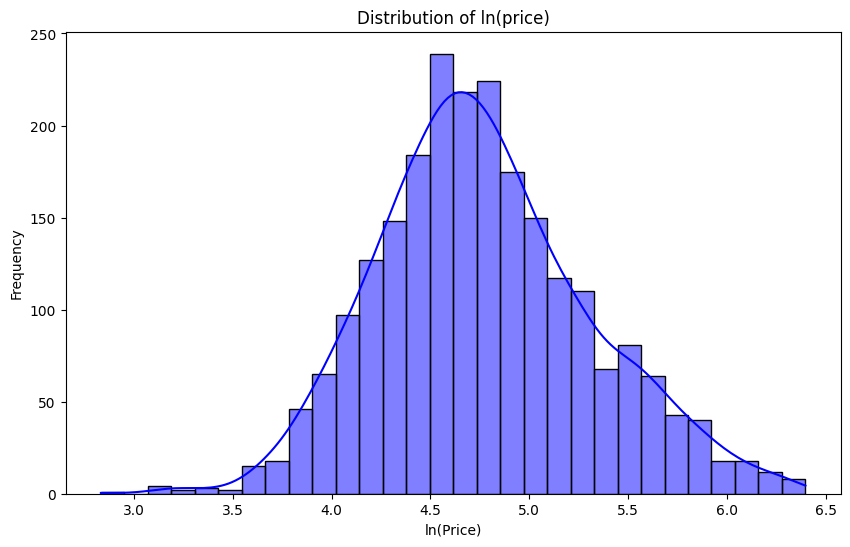

In [1005]:
# Add a new column of ln(price)
data['ln_price'] = np.log(data['price'])

# Visualize distribution of ln(price) column
plt.figure(figsize=(10, 6))
sns.histplot(data['ln_price'], kde=True, color='blue', bins=30)
plt.title('Distribution of ln(price)')
plt.xlabel('ln(Price)')
plt.ylabel('Frequency')
plt.show()

### Feature Engineering

From this point on, we need to determine which variables and interactions will be used in our models. After this step, we need to divide the data set into two separate parts as train and test (hold_out), train the model with the train data set and test the model with the test data set. The result we obtain with the test data set is the performance result of the model. These steps constitute feature engineering.

In [1006]:
# renaming the columns to have a better understanding and defining a mapping dictionary for renaming
mapping = {'host_response_time': 'f_host_response_time', 
           'host_response_rate': 'n_host_response_rate',
           'host_acceptance_rate': 'n_host_acceptance_rate', 
           'host_is_superhost': 'd_host_is_superhost',
           'neighbourhood_cleansed': 'f_neighbourhood_cleansed', 
           'property_type': 'f_property_type',
           'room_type': 'f_room_type', 
           'accommodates': 'n_accommodates', 
           'beds': 'n_beds', 
           'maximum_nights': 'n_maximum_nights', 
           'availability_90': 'n_availability_90',
           'number_of_reviews': 'n_number_of_reviews', 
           'review_scores_rating': 'n_review_scores_rating'}

# renaming the columns using the mapping dictionary
data_final = data.rename(columns=mapping)

In [1007]:
# splitting the data into two sets (train and test)
data_train, data_holdout = train_test_split(data_final, train_size=0.8, random_state=42)

In [1008]:
data_train.shape, data_holdout.shape

((1837, 71), (460, 71))

In [1009]:
# renaming the columns in data to be used in our analysis by adding f_, n_ and d_ prefixes
data_final.columns

Index(['id', 'listing_url', 'scrape_id', 'last_scraped', 'source', 'name',
       'neighborhood_overview', 'picture_url', 'host_id', 'host_url',
       'host_name', 'host_since', 'host_location', 'host_about',
       'f_host_response_time', 'n_host_response_rate',
       'n_host_acceptance_rate', 'd_host_is_superhost', 'host_thumbnail_url',
       'host_picture_url', 'host_neighbourhood', 'host_listings_count',
       'host_total_listings_count', 'host_verifications',
       'host_has_profile_pic', 'host_identity_verified', 'neighbourhood',
       'f_neighbourhood_cleansed', 'latitude', 'longitude', 'f_property_type',
       'f_room_type', 'n_accommodates', 'bathrooms_text', 'n_beds',
       'amenities', 'price', 'minimum_nights', 'n_maximum_nights',
       'minimum_minimum_nights', 'maximum_minimum_nights',
       'minimum_maximum_nights', 'maximum_maximum_nights',
       'minimum_nights_avg_ntm', 'maximum_nights_avg_ntm', 'has_availability',
       'availability_30', 'availability_60

In [1010]:
# these variables were selected to compare in our ML models
basic_vars = [
    "n_accommodates",
    "n_beds",
    "f_property_type",
    "f_room_type",
    "n_bathrooms",
    "f_neighbourhood_cleansed",
    "n_availability_90", # column gives the number of days a listing is available out of 90 days
    "n_maximum_nights", # ömaz number of nights to book the place
    "f_host_response_time",
    "n_host_response_rate",
    "n_host_acceptance_rate",
]

# reviews
reviews = [
    "n_number_of_reviews",
    "n_review_scores_rating",
]

# dummy variables
super_host = ["d_host_is_superhost"]

# interactions for the LASSO
X1 = [
    "n_accommodates:f_property_type",
    "f_room_type:f_property_type",
]
# with boroughs
X2 = [
    "f_property_type:f_neighbourhood_cleansed",
    "f_room_type:f_neighbourhood_cleansed",
    "n_accommodates:f_neighbourhood_cleansed",
]

In [1011]:
predictors_1 = basic_vars
predictors_2 = basic_vars + reviews + super_host
predictors_E = basic_vars + reviews + X1 + X2

### Modelling

##### Model1: Random Forest

A random forest is a meta estimator that fits a number of classifying decision trees on various sub-samples of the dataset and uses averaging to improve the predictive accuracy and control over-fitting. 

In [1012]:
# creating y-vector (dependant variable) and X-matrice (explanatory variables)
y, X = dmatrices("ln_price ~ " + " + ".join(predictors_2), data_train) # we created this to compare OLS with log(price)
y2, X22 = dmatrices("price ~ " + " + ".join(predictors_2), data_train) 

In [1013]:
# X matrice is created in a way that every category in categorical variable is taken as a seperate column
X

DesignMatrix with shape (1837, 28)
  Columns:
    ['Intercept',
     'f_property_type[T.Entire home]',
     'f_property_type[T.Entire loft]',
     'f_property_type[T.Entire rental unit]',
     'f_property_type[T.Entire serviced apartment]',
     'f_property_type[T.Entire vacation home]',
     'f_property_type[T.Private room in bed and breakfast]',
     'f_property_type[T.Private room in condo]',
     'f_property_type[T.Private room in home]',
     'f_property_type[T.Private room in rental unit]',
     'f_room_type[T.Private room]',
     'f_neighbourhood_cleansed[T.Centro Storico]',
     'f_neighbourhood_cleansed[T.Gavinana Galluzzo]',
     'f_neighbourhood_cleansed[T.Isolotto Legnaia]',
     'f_neighbourhood_cleansed[T.Rifredi]',
     'f_host_response_time[T.within a day]',
     'f_host_response_time[T.within a few hours]',
     'f_host_response_time[T.within an hour]',
     'n_accommodates',
     'n_beds',
     'n_bathrooms',
     'n_availability_90',
     'n_maximum_nights',
     'n_

In [1014]:
# a two-dimensional object
y.shape

(1837, 1)

In [1015]:
# using ravel() we flatten it to a one-dimensional data object. 
y.ravel().shape

(1837,)

In [1016]:
# creating the Random Forest Regressor of sklearn package
rfr = RandomForestRegressor(random_state = 42)

In [1017]:
tune_grid = {"max_features": [6, 8, 10, 12], "min_samples_leaf": [5, 10, 15]}

In [1018]:
# creating regressors for level prices and one for log prices
# finding the best values for hyperparameters of a model

rf_random = GridSearchCV(
    rfr,
    tune_grid,
    cv=5,
    scoring="neg_root_mean_squared_error",
    verbose=3,
)


rf_random2 = GridSearchCV(
    rfr,
    tune_grid,
    cv=5,
    scoring="neg_root_mean_squared_error",
    verbose=3,
)

`GridsearchCV()` is an exhaustive search over specified parameter values for an estimator.

<br>

Cross-validated results are saved in the grid search object's `cv_results_` attribute. *RMSE* is displayed as a negative number. 

In [1019]:
%%time
rf_model_log = rf_random.fit(X, y.ravel())
rf_model_level = rf_random2.fit(X22, y2.ravel())

Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV 1/5] END max_features=6, min_samples_leaf=5;, score=-0.407 total time=   0.1s
[CV 2/5] END max_features=6, min_samples_leaf=5;, score=-0.398 total time=   0.1s
[CV 3/5] END max_features=6, min_samples_leaf=5;, score=-0.396 total time=   0.1s
[CV 4/5] END max_features=6, min_samples_leaf=5;, score=-0.396 total time=   0.1s
[CV 5/5] END max_features=6, min_samples_leaf=5;, score=-0.409 total time=   0.1s
[CV 1/5] END max_features=6, min_samples_leaf=10;, score=-0.416 total time=   0.1s
[CV 2/5] END max_features=6, min_samples_leaf=10;, score=-0.410 total time=   0.1s
[CV 3/5] END max_features=6, min_samples_leaf=10;, score=-0.402 total time=   0.1s
[CV 4/5] END max_features=6, min_samples_leaf=10;, score=-0.403 total time=   0.1s
[CV 5/5] END max_features=6, min_samples_leaf=10;, score=-0.421 total time=   0.1s
[CV 1/5] END max_features=6, min_samples_leaf=15;, score=-0.421 total time=   0.1s
[CV 2/5] END max_features=6, mi

In [1020]:
df_rf_model_cv_results = pd.DataFrame(rf_model_log.cv_results_)[[
    'param_max_features', 'param_min_samples_leaf', 'mean_test_score']]
df_rf_model2_cv_results = pd.DataFrame(rf_model_level.cv_results_)[[
    'param_max_features', 'param_min_samples_leaf', 'mean_test_score']]

In [1021]:
# renaming columns of the results of first random forest model (df_rf_model with ln(price))
df_rf_model_cv_results.columns = ['max features', 'min node size', 'RMSE_ln']

# calculating the mean price
mean_price_ln = np.mean(y)
mean_price_level = np.mean(y2)

# calculating prediction error percentage
rmse_values_ln = -df_rf_model_cv_results['RMSE_ln']
df_rf_model_cv_results['RMSE_ln'] = rmse_values_ln
error_percentage_ln = (rmse_values_ln / mean_price_ln)

rmse_values_level = -df_rf_model2_cv_results['mean_test_score']
error_percentage_level = (rmse_values_level / mean_price_level)

# adding prediction error percentage to the DataFrame
df_rf_model_cv_results['RMSE_percentage_ln'] = error_percentage_ln

# adding RMSE of level price as y to the DataFrame
df_rf_model_cv_results['RMSE_level'] = rmse_values_level

# adding prediction error percentage of level price as y to the DataFrame
df_rf_model_cv_results['RMSE_percentage_level'] = error_percentage_level

In [1022]:
df_rf_model_cv_results

,max features,min node size,RMSE_ln,RMSE_percentage_ln,RMSE_level,RMSE_percentage_level
0,6,5,0.401256,0.084278,66.879155,0.491069
1,6,10,0.410373,0.086193,67.986652,0.499201
2,6,15,0.416263,0.087431,68.786722,0.505075
3,8,5,0.401734,0.084379,66.946072,0.491560
4,8,10,0.406613,0.085404,67.747330,0.497443
5,8,15,0.412805,0.086704,68.241602,0.501073
6,10,5,0.401679,0.084367,66.816975,0.490612
7,10,10,0.409051,0.085916,67.646537,0.496703
8,10,15,0.411237,0.086375,68.362280,0.501959
9,12,5,0.400065,0.084029,66.963358,0.491687


RMSE for level prices for different models of Random Forest is between 66 and 68. And comparing these values to mean prices, we get approximately 50% error. For log transformed predictions, this raito is around 8%. Although, Random Forest is said to not sensitive to non-normality, the results are a bit confusing.

In [1023]:
print(-rf_model_level.best_score_)
print(rf_model_level.best_params_)

66.81697525672766
{'max_features': 10, 'min_samples_leaf': 5}


- The best Random Forest model has minimum 5 an observations in a terminal node and with max 10 number of features that are considered when splitting a node

In [1024]:
rf_model_level.best_estimator_

RandomForestRegressor(max_features=10, min_samples_leaf=5, random_state=42)

We have used some different columns than London data in our analysis and found similar results. The best model hast 10 features and 5 leafs similar to London data. Also, we found near proportion between RMSE values and the mean acc. to London results.

We also applied $log(price)$ as dependant variable and compared the results with level-prices. Random forest finds the best model with same specifications but `RMSE/mean(price)` ratio is very different in case of log-transformed prices as `y-variable`.

**Model1 Diagnostics**

In [1025]:
rf_model_level.best_estimator_.feature_importances_

array([0.00000000e+00, 8.48171750e-04, 1.78904139e-03, 1.07254255e-02,
       4.68877969e-04, 5.53344136e-06, 8.72031558e-04, 6.69816500e-04,
       1.48719208e-04, 1.83709680e-02, 3.19239568e-02, 4.05974894e-02,
       2.15164813e-04, 1.04700307e-03, 2.66617736e-03, 1.37747011e-03,
       2.39300493e-03, 5.00098074e-03, 9.27754363e-02, 9.78548639e-02,
       2.51491240e-01, 9.63047386e-02, 5.64840976e-02, 2.65505318e-02,
       3.49821858e-02, 1.12446118e-01, 9.60015931e-02, 1.59893627e-02])

In [1026]:
X.design_info.column_names

['Intercept',
 'f_property_type[T.Entire home]',
 'f_property_type[T.Entire loft]',
 'f_property_type[T.Entire rental unit]',
 'f_property_type[T.Entire serviced apartment]',
 'f_property_type[T.Entire vacation home]',
 'f_property_type[T.Private room in bed and breakfast]',
 'f_property_type[T.Private room in condo]',
 'f_property_type[T.Private room in home]',
 'f_property_type[T.Private room in rental unit]',
 'f_room_type[T.Private room]',
 'f_neighbourhood_cleansed[T.Centro Storico]',
 'f_neighbourhood_cleansed[T.Gavinana Galluzzo]',
 'f_neighbourhood_cleansed[T.Isolotto Legnaia]',
 'f_neighbourhood_cleansed[T.Rifredi]',
 'f_host_response_time[T.within a day]',
 'f_host_response_time[T.within a few hours]',
 'f_host_response_time[T.within an hour]',
 'n_accommodates',
 'n_beds',
 'n_bathrooms',
 'n_availability_90',
 'n_maximum_nights',
 'n_host_response_rate',
 'n_host_acceptance_rate',
 'n_number_of_reviews',
 'n_review_scores_rating',
 'd_host_is_superhost']

In [1027]:
df_var_imp = pd.DataFrame(
    rf_model_level.best_estimator_.feature_importances_, 
    X.design_info.column_names)\
    .reset_index()\
    .rename({"index": "variable", 0: "imp"}, axis=1)\
    .sort_values(by=["imp"], ascending=False)\
    .reset_index(drop = True)

df_var_imp['cumulative_imp'] = df_var_imp['imp'].cumsum()

In [1028]:
df_var_imp.style.format({
    'imp': lambda x: f'{x:,.1%}',
    'cumulative_imp': lambda x: f'{x:,.1%}'})

,variable,imp,cumulative_imp
0,n_bathrooms,25.1%,25.1%
1,n_number_of_reviews,11.2%,36.4%
2,n_beds,9.8%,46.2%
3,n_availability_90,9.6%,55.8%
4,n_review_scores_rating,9.6%,65.4%
5,n_accommodates,9.3%,74.7%
6,n_maximum_nights,5.6%,80.3%
7,f_neighbourhood_cleansed[T.Centro Storico],4.1%,84.4%
8,n_host_acceptance_rate,3.5%,87.9%
9,f_room_type[T.Private room],3.2%,91.1%


In terms of individual importances, `n_bathrooms` that can stay at the listing have highest importance.

In [1029]:
# we only care for variables with an importance of more than 1%
cutoff = 0.01

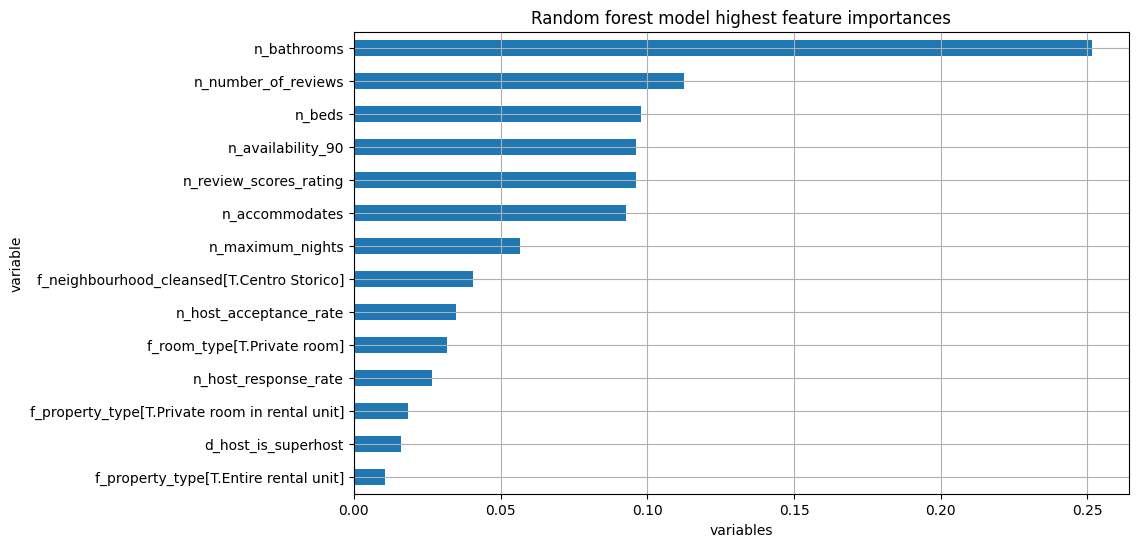

In [1030]:
df_var_imp[df_var_imp.imp > cutoff]\
    .sort_values(by = 'imp')\
    .plot(kind = 'barh', 
          x = 'variable', y = 'imp', 
          figsize = (10,6), grid = True, 
          title = 'Random forest model highest feature importances', 
          xlabel = 'variables', legend = False
         );

Now we group variable importance. In other words, instead of looking at the individual categories of a categorical variable, we look at the total effect of the category.

In [1031]:
categorical_columns = [col for col in predictors_2 if col.startswith("f_")]
numerical_columns = [col for col in predictors_2 if col not in categorical_columns]

In [1032]:
categorical_encoder = OneHotEncoder(handle_unknown="ignore")

preprocessing = ColumnTransformer([
    ("cat", categorical_encoder, categorical_columns),
    ("num", "passthrough", numerical_columns)])

rf_pipeline = Pipeline(
    [("preprocess", preprocessing), 
     ("regressor", rf_model_level.best_estimator_)] # for level
)

rf_pipeline2 = Pipeline(
    [("preprocess", preprocessing), 
     ("regressor", rf_model_log.best_estimator_)] # for log
)

In [1033]:
%%time
rf_pipeline.fit(data_train[predictors_2],data_train.price)

CPU times: user 457 ms, sys: 3.81 ms, total: 461 ms
Wall time: 159 ms


Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['f_property_type',
                                                   'f_room_type',
                                                   'f_neighbourhood_cleansed',
                                                   'f_host_response_time']),
                                                 ('num', 'passthrough',
                                                  ['n_accommodates', 'n_beds',
                                                   'n_bathrooms',
                                                   'n_availability_90',
                                                   'n_maximum_nights',
                                                   'n_host_response_rate',
                                                   'n_host_acceptance_rate',
                                                   'n_number_of_reviews',
                                                   'n_review_scores_rating',
                                                   'd_host_is_superhost'])])),
                ('regressor',
                 RandomForestRegressor(max_features=10, min_samples_leaf=5,
                                       random_state=42))])

In [1034]:
%%time
rf_pipeline2.fit(data_train[predictors_2],data_train.ln_price)

CPU times: user 166 ms, sys: 1.96 ms, total: 168 ms
Wall time: 167 ms


Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['f_property_type',
                                                   'f_room_type',
                                                   'f_neighbourhood_cleansed',
                                                   'f_host_response_time']),
                                                 ('num', 'passthrough',
                                                  ['n_accommodates', 'n_beds',
                                                   'n_bathrooms',
                                                   'n_availability_90',
                                                   'n_maximum_nights',
                                                   'n_host_response_rate',
                                                   'n_host_acceptance_rate',
                                                   'n_number_of_reviews',
                                                   'n_review_scores_rating',
                                                   'd_host_is_superhost'])])),
                ('regressor',
                 RandomForestRegressor(max_features=12, min_samples_leaf=5,
                                       random_state=42))])

In [1035]:
%%time
result = permutation_importance(
    rf_pipeline,
    data_holdout[predictors_2],
    data_holdout.price,
    n_repeats=10,
    random_state=45,
)

CPU times: user 738 ms, sys: 3.28 ms, total: 742 ms
Wall time: 741 ms


In [1036]:
pd.DataFrame(
        result.importances_mean,
        data_train[predictors_2].columns)

,0
n_accommodates,0.040229
n_beds,0.035192
f_property_type,0.003505
f_room_type,0.040206
n_bathrooms,0.205473
f_neighbourhood_cleansed,0.026416
n_availability_90,0.011035
n_maximum_nights,0.022245
f_host_response_time,-0.000248
n_host_response_rate,0.021490


In [1037]:
grouped = [
    "n_beds",
    "f_property_type",
    "f_room_type",
    "n_accommodates",
    "n_bathrooms",
    "f_neighbourhood_cleansed",
    "n_availability_90",
    "n_maximum_nights",
    "f_host_response_time",
    "n_host_response_rate",
    "n_host_acceptance_rate",
    "n_number_of_reviews",
    "n_review_scores_rating",
    "d_host_is_superhost"
]

In [1038]:
df_grouped_var_imp = pd.DataFrame(
        result.importances_mean,
        data_train[predictors_2].columns)\
    .loc[grouped]\
    .sort_values(by = 0, ascending = False)\
    .reset_index()\
    .rename({'index': 'variable', 0: 'imp'}, axis = 1)
df_grouped_var_imp['cumulative_imp'] = df_grouped_var_imp.imp.cumsum()

In [1039]:
df_grouped_var_imp.style.format({
    'imp': lambda x: f'{x:,.1%}',
    'cumulative_imp': lambda x: f'{x:,.1%}'})

,variable,imp,cumulative_imp
0,n_bathrooms,20.5%,20.5%
1,n_number_of_reviews,5.3%,25.9%
2,n_accommodates,4.0%,29.9%
3,f_room_type,4.0%,33.9%
4,n_beds,3.5%,37.4%
5,n_review_scores_rating,2.7%,40.2%
6,f_neighbourhood_cleansed,2.6%,42.8%
7,n_maximum_nights,2.2%,45.0%
8,n_host_response_rate,2.1%,47.2%
9,n_availability_90,1.1%,48.3%


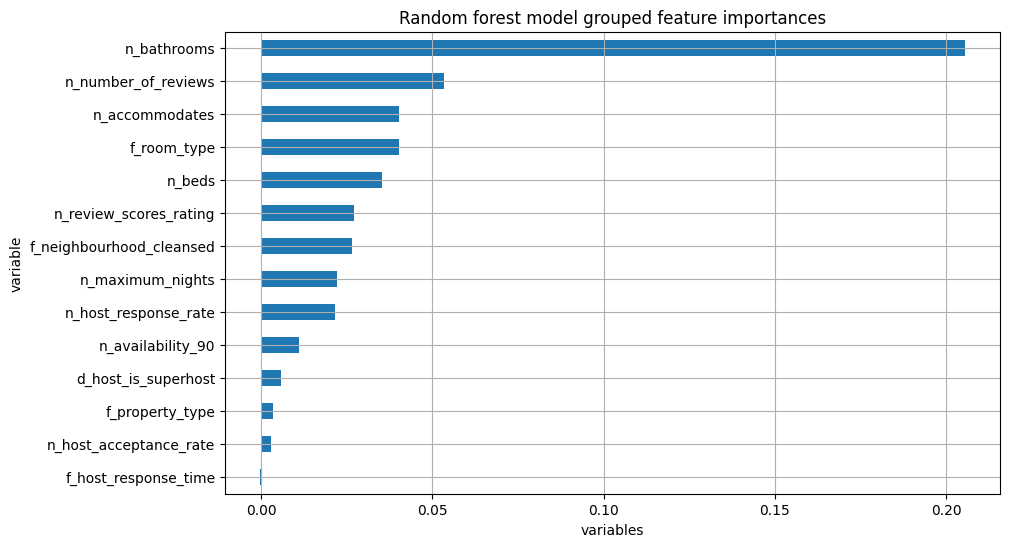

In [1040]:
df_grouped_var_imp\
    .sort_values(by = 'imp')\
    .plot(kind = 'barh', 
          x = 'variable', y = 'imp', 
          figsize = (10,6), grid = True, 
          title = 'Random forest model grouped feature importances', 
          xlabel = 'variables', legend = False
         );

In [1041]:
df_clean_varimp = pd.DataFrame(
        result.importances_mean,
        data_train[predictors_2].columns)\
    .sort_values(by = 0, ascending = False)\
    .reset_index()\
    .rename({'index': 'variable', 0: 'imp'}, axis = 1)

df_clean_varimp['cumulative_imp'] = df_var_imp['imp'].cumsum()
df_clean_varimp[df_clean_varimp.cumulative_imp < 0.91]

,variable,imp,cumulative_imp
0,n_bathrooms,0.205473,0.251491
1,n_number_of_reviews,0.053304,0.363937
2,n_accommodates,0.040229,0.461792
3,f_room_type,0.040206,0.558097
4,n_beds,0.035192,0.654099
5,n_review_scores_rating,0.027173,0.746874
6,f_neighbourhood_cleansed,0.026416,0.803358
7,n_maximum_nights,0.022245,0.843956
8,n_host_response_rate,0.021490,0.878938


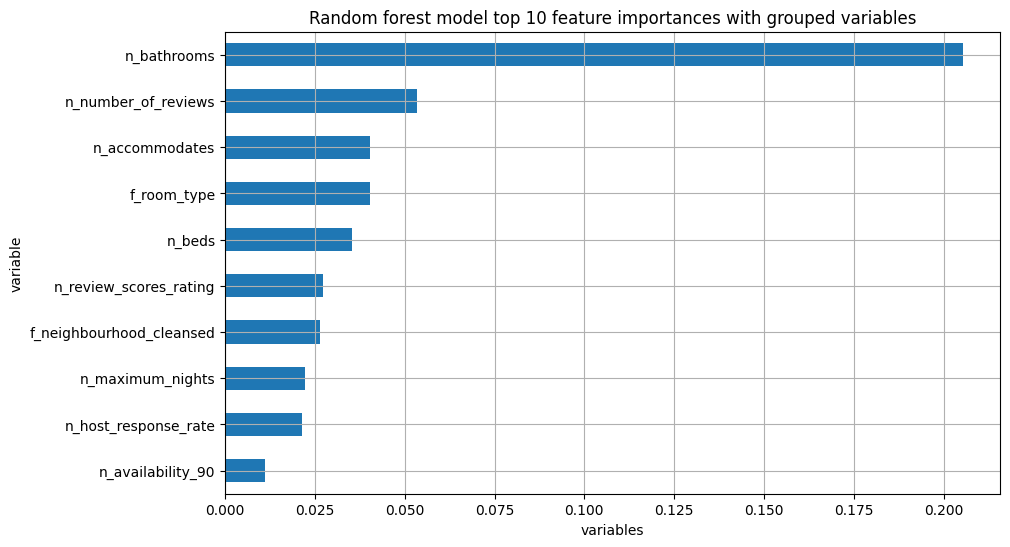

In [1042]:
df_clean_varimp.iloc[0:10]\
    .sort_values(by = 'imp')\
    .plot(kind = 'barh', 
          x = 'variable', y = 'imp', 
          figsize = (10,6), grid = True, 
          title = 'Random forest model top 10 feature importances with grouped variables', 
          xlabel = 'variables', legend = False
         );

Variable importances analysis show that, the most important factor (20%)for apartments in Florence is the 'n_baths' that the apartment can host. `n_number_reviews` and `n_accommodates` are the 2nd and 3th important factors, respectively.

**Partial dependence plots** 

Partial dependence plots show the dependence between the target function and a set of features of interest, marginalizing over the values of all other features (the complement features). While feature importance shows what variables most affect predictions, partial dependence plots show how a feature affects predictions.

In [1043]:
# checking how number of accommodates (found to most important factor) affect prices
bathrooms_pdp = partial_dependence(
    rf_pipeline, data_holdout[predictors_2], ["n_bathrooms"], kind="average"
)

In [1044]:
pd.DataFrame(
    {'number of bathrooms': bathrooms_pdp['values'][0], 
     'average price': bathrooms_pdp['average'][0]}
    )

,number of bathrooms,average price
0,1.0,123.604621
1,1.5,135.346837
2,2.0,172.758288
3,2.5,193.596473
4,3.0,202.642299


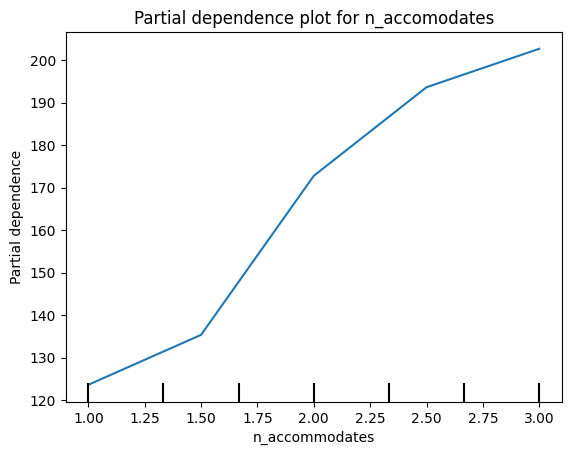

[CV 3/5; 1/4] START max_depth=5, n_estimators=200...............................
[CV 3/5; 1/4] END max_depth=5, n_estimators=200;, score=-61.478 total time=   0.2s
[CV 3/5; 3/4] START max_depth=10, n_estimators=200..............................
[CV 3/5; 3/4] END max_depth=10, n_estimators=200;, score=-64.226 total time=   0.3s
[CV 5/5; 4/4] START max_depth=10, n_estimators=300..............................
[CV 5/5; 4/4] END max_depth=10, n_estimators=300;, score=-71.261 total time=   0.4s
[CV 5/5; 1/4] START max_depth=5, n_estimators=200...............................
[CV 5/5; 1/4] END max_depth=5, n_estimators=200;, score=-0.390 total time=   0.2s
[CV 3/5; 3/4] START max_depth=10, n_estimators=200..............................
[CV 3/5; 3/4] END max_depth=10, n_estimators=200;, score=-0.410 total time=   0.4s
[CV 1/5; 2/4] START max_depth=5, n_estimators=300...............................
[CV 1/5; 2/4] END max_depth=5, n_estimators=300;, score=-75.139 total time=   0.3s
[CV 5/5; 3/4] S

In [1104]:
display = PartialDependenceDisplay(
    pd_results = [bathrooms_pdp],
    features = [(0,)], 
    feature_names = data_holdout[predictors_2].columns.tolist(), 
    target_idx = 0,
    deciles = {0: np.linspace(1, 3, num=7)}
)
display.plot()
plt.title('Partial dependence plot for n_accomodates')
plt.show();

There is a clear effect in the expected direction of number of acoomodates on prices.

In [1046]:
roomtype_pdp = partial_dependence(
    rf_pipeline, data_holdout[predictors_2], ["f_room_type"], kind="average"
)

In [1047]:
roomtype_pdp

{'grid_values': [array(['Entire home/apt', 'Private room'], dtype=object)],
 'values': [array(['Entire home/apt', 'Private room'], dtype=object)],
 'average': array([[137.31847529, 104.48541309]])}

In [1048]:
roomtype_pdp['average'][0]

array([137.31847529, 104.48541309])

In [1049]:
roomtype_pdp['values'][0]

array(['Entire home/apt', 'Private room'], dtype=object)

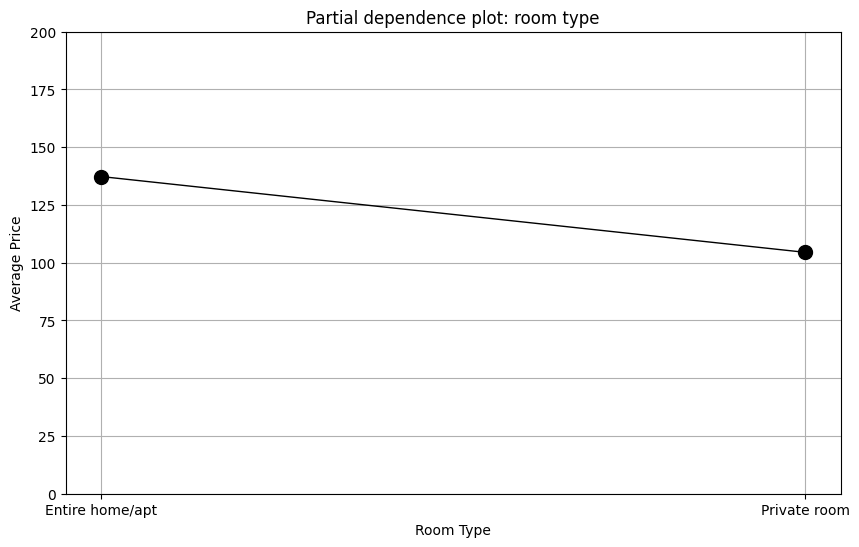

In [1050]:
# creating DataFrame from the dictionary
df = pd.DataFrame({'room type': roomtype_pdp['values'][0], 'average price': roomtype_pdp['average'][0]})

# plotting
plt.figure(figsize=(10, 6))
plt.plot(df['room type'], df['average price'], color='k', marker='o', markersize=10, linewidth=1)
plt.ylim(0, 200)
plt.title('Partial dependence plot: room type')
plt.xlabel('Room Type')
plt.ylabel('Average Price')
plt.grid(True)

# setting x-axis labels manually
plt.xticks(range(len(df['room type'])), df['room type'])

plt.show()

Room type which is categorical variable found to be fourth most important factor that affect the prices. Private rooms seem cheaper than an entire home, which is expected.

**SHAP Importance**

 97%|=================== | 447/460 [00:13<00:00]       

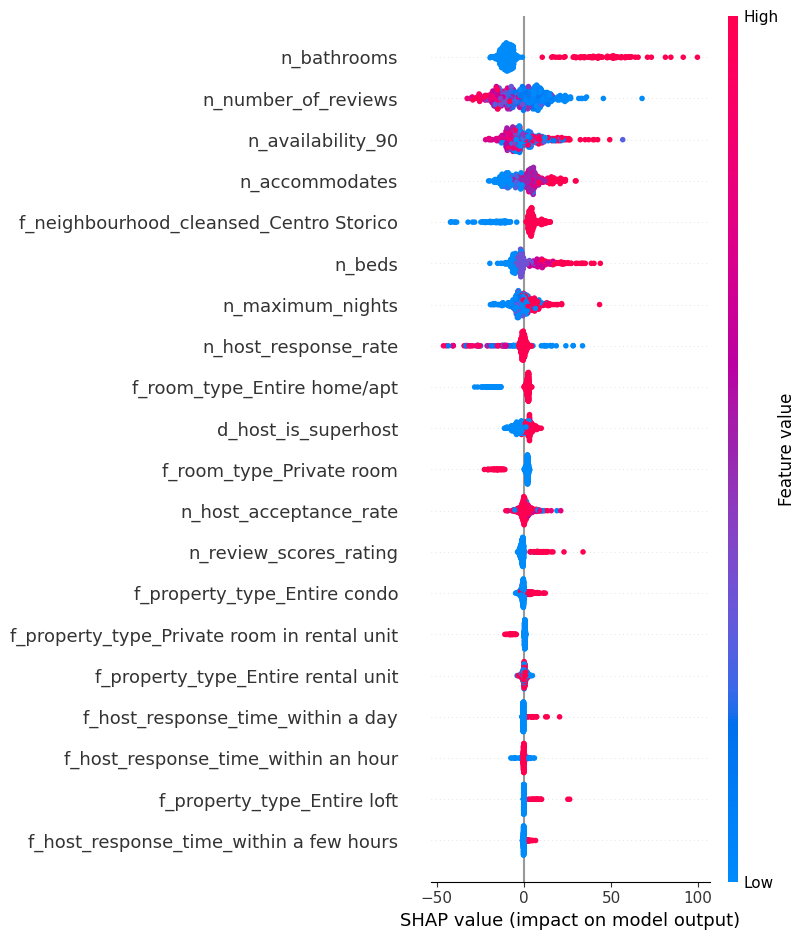

In [1051]:
import shap

columns_to_filter = [
    "n_accommodates",
    "n_beds",
    "f_property_type",
    "f_room_type",
    "n_bathrooms",
    "f_neighbourhood_cleansed",
    "n_availability_90", 
    "n_maximum_nights", 
    "f_host_response_time",
    "n_host_response_rate",
    "n_host_acceptance_rate",
    "n_number_of_reviews",
    "n_review_scores_rating",
    "d_host_is_superhost", 
    "price", 
    "ln_price"] 

data_for_shap = data_final[columns_to_filter].copy()

# performing one-hot encoding for the 'category' column
data_encoded = pd.get_dummies(data_for_shap, columns=["f_property_type","f_room_type",
                                                      "f_neighbourhood_cleansed", "f_host_response_time"])


data_encoded = data_encoded.astype(int)

# splitting the data into features (X) and target (y)
X_shap = data_encoded.drop(['price', 'ln_price'], axis=1)
y_shap = data_encoded['price']

# splitting the data into training and test sets
X_train_shap, X_test_shap, y_train_shap, y_test_shap = train_test_split(X_shap, y_shap, test_size=0.2, random_state=42)

# training a Random Forest model
model_shap = RandomForestRegressor(random_state=42)
model_shap.fit(X_train_shap, y_train_shap)

# creating a SHAP explainer
explainer = shap.Explainer(model_shap, X_train_shap)

# computing SHAP values
shap_values = explainer(X_test_shap)

# plotting SHAP values
shap.summary_plot(shap_values, X_test_shap)

**Subsample performance: RMSE / mean(y)**

The Test/Holdout RMSE is computed by applying the test data to the models and using the predicted values for evaluation. We will then contrast both the cross-validated RMSE values and the test RMSE values across the various alternative ML models.

In [1052]:
data_holdout_w_prediction = data_holdout.assign(
    predicted_price=rf_pipeline.predict(data_holdout[predictors_2])
)

In [1053]:
data_holdout_w_prediction2 = data_holdout.assign(
    predicted_price=rf_pipeline2.predict(data_holdout[predictors_2])
)

In [1054]:
# RMSE on holdout/test data

rf_test_rmse_level_price = np.sqrt((sum((data_holdout_w_prediction['predicted_price']-
                                         data_holdout_w_prediction['price'])**2))/len(data_holdout_w_prediction))
print("RMSE on Holdout/Test Data for Random Forest With Level Prices:", rf_test_rmse_level_price)

RMSE on Holdout/Test Data for Random Forest With Level Prices: 65.40649353352404


In [1055]:
# RMSE of ln_price on holdout/test data

rf_test_rmse_log_price = np.sqrt((sum((data_holdout_w_prediction2['predicted_price']-
                                      data_holdout_w_prediction2['ln_price'])**2))/len(data_holdout_w_prediction2))
print("RMSE on Holdout/Test Data for Random Forest With Log Prices:", rf_test_rmse_log_price)

RMSE on Holdout/Test Data for Random Forest With Log Prices: 0.3835984346164461


**Creating tables of heterogeneity by various grouping factors**

In this part we can check how model performance changes for different categories of categorical variables. By creating a new grouping using a numeric variable, model performance can even be tested on these artificially produced groups.

- Apartment size: In our analysis for Florence, apartment sizes are between 2-6 people. If we assume apartments with 2-3 people are small apartments and  4-6 are large apartments, we can compare the model performance between these two grpups.

In [1107]:
data_holdout_w_prediction['is_low_size'] = data_holdout_w_prediction.n_accommodates.map(lambda x: 'small apt' 
                                                                                        if x <= 3 else 'large apt')

In [1057]:
data_holdout_w_prediction.iloc[0:5, -3:]

,ln_price,predicted_price,is_low_size
1168,4.532599,134.605340,small apt
4093,5.164786,144.229570,large apt
614,3.637586,88.161180,small apt
6728,5.802118,285.513714,large apt
825,4.934474,129.328680,large apt


In [1058]:
data_holdout_w_prediction.groupby('is_low_size').apply(lambda x: mean_squared_error(x.predicted_price, x.price, squared=False))

is_low_size
large apt    70.932979
small apt    56.105188
dtype: float64

Putting it in a function with additional columns

In [1059]:
def calculate_rmse(groupby_obj):
    return (
        groupby_obj.apply(
            lambda x: mean_squared_error(x.predicted_price, x.price, squared=False),
        )
        .to_frame(name="rmse")
        .assign(mean_price=groupby_obj.apply(lambda x: np.mean(x.price)).values)
        .assign(rmse_norm=lambda x: x.rmse / x.mean_price).round(2)
    )

In [1060]:
# cheaper or more expensive flats 
grouped_object = data_holdout_w_prediction.assign(
    is_low_size=lambda x: np.where(x.n_accommodates <= 3, "small apt", "large apt")
).groupby("is_low_size")
accom_subset = calculate_rmse(grouped_object)

In [1061]:
accom_subset

,rmse,mean_price,rmse_norm
is_low_size,,,
large apt,70.93,161.87,0.44
small apt,56.11,107.86,0.52


Although the mean prices is lower for small size apartments, we found a higher RMSE/mean(y) for this category.

The analysis can be extended to compare room types, property types and neighbourhoods. In order not to make the analysis too long, we will only compare model performance according to apartment sizes.

##### Model2: Ordinary Least Squares Regression (OLS)

For OLS and LASSO, utilizing log-transformed price data is advisable because OLS is susceptible to non-normal data, unlike Random Forest. Subsequently, we can assess RMSE values for all three models when the target variable is ln(price). Each model (Random Forest, OLS, LASSO, and GBM) is executed for both level and log prices.

In [1062]:
from sklearn.linear_model import LinearRegression

In [1063]:
y, X = dmatrices("price ~ " + " + ".join(predictors_2), data_train)
y2, X22 = dmatrices("ln_price ~ " + " + ".join(predictors_2), data_train)

ols_model = LinearRegression().fit(X,y)
ols_model2 = LinearRegression().fit(X22,y2)

y_hat = ols_model.predict(X)
y_hat2 = ols_model2.predict(X22)

In [1064]:
# 1. Evaluating the Model Performance
ols_rmse = mean_squared_error(y,y_hat,squared=False)
print("RMSE:", ols_rmse)

ols_rmse_log = mean_squared_error(y2,y_hat2,squared=False)
print("RMSE of log model:", ols_rmse_log)

from sklearn.metrics import r2_score
r2 = r2_score(y, y_hat)
print("R-squared:", r2)

r2_ln = r2_score(y2, y_hat2)
print("R-squared of log model:", r2_ln)

RMSE: 68.44018669673957
RMSE of log model: 0.41804230789625135
R-squared: 0.3443857789583782
R-squared of log model: 0.3969934420761172


In [1065]:
# 2. Checking for Assumptions
# Using statsmodels' OLS to perform diagnostic tests
import statsmodels.api as sm

ols_model_stats = sm.OLS(y, X).fit()
print(ols_model_stats.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.344
Model:                            OLS   Adj. R-squared:                  0.335
Method:                 Least Squares   F-statistic:                     36.57
Date:                Sun, 11 Feb 2024   Prob (F-statistic):          2.29e-145
Time:                        22:24:59   Log-Likelihood:                -10370.
No. Observations:                1837   AIC:                         2.079e+04
Df Residuals:                    1810   BIC:                         2.094e+04
Df Model:                          26                                         
Covariance Type:            nonrobust                                         
                                                           coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------

In [1066]:
# 3. Cross-validation
# Performing 5-fold cross-validation
from sklearn.model_selection import cross_val_score

cv_scores = cross_val_score(ols_model, X, y, cv=5, scoring='neg_mean_squared_error')
cv_rmse_scores = np.sqrt(-cv_scores)

cv_scores_log = cross_val_score(ols_model, X22, y2, cv=5, scoring='neg_mean_squared_error')
cv_rmse_scores_log = np.sqrt(-cv_scores_log)

print("Cross-Validation RMSE Scores:", cv_rmse_scores)
print("Average Cross-Validation RMSE Score (level prices):", np.average(cv_rmse_scores))

print("Cross-Validation RMSE Scores For Log-Transformed Prices:", cv_rmse_scores_log)
print("Average Cross-Validation RMSE Score (log prices):", np.average(cv_rmse_scores_log))

Cross-Validation RMSE Scores: [75.53853473 67.32622172 65.40804823 66.03831393 72.7321498 ]
Average Cross-Validation RMSE Score (level prices): 69.4086536844479
Cross-Validation RMSE Scores For Log-Transformed Prices: [0.42195518 0.42736825 0.41495135 0.41886923 0.44665436]
Average Cross-Validation RMSE Score (log prices): 0.4259596735247565


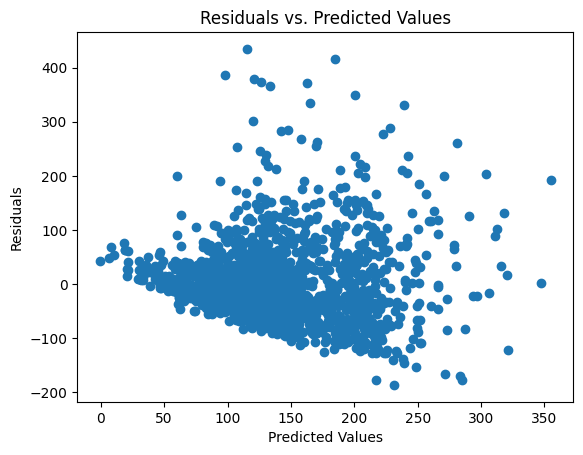

In [1067]:
# 4. Visualization
# Plotting residuals
residuals = y - y_hat
plt.scatter(y_hat, residuals)
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.title("Residuals vs. Predicted Values")
plt.show()


- Due to the presence of heteroskedastic residuals, it makes sente to utilize log-transformed prices for the analysis.

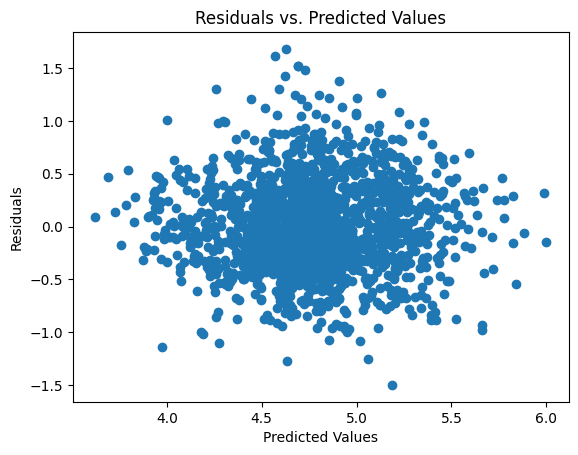

In [1068]:
# plotting residuals of log transformed prices
residuals2 = y2 - y_hat2
plt.scatter(y_hat2, residuals2)
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.title("Residuals vs. Predicted Values")
plt.show()

- While not entirely eliminating the issue, heteroskedasticity appears to be mitigated to some extent when utilizing log-transformed price data.

In [1069]:
# 5. Calculating RMSE on test/holdout data

y_test, X_test = dmatrices("price ~ " + " + ".join(predictors_2), data_holdout)
y_test2, X_test2 = dmatrices("ln_price ~ " + " + ".join(predictors_2), data_holdout)

# Predicting the target variable on the test dataset
y_hat_test = ols_model.predict(X_test)
y_hat_test2 = ols_model2.predict(X_test2)


# Computing the RMSE
ols_rmse_test = mean_squared_error(y_test, y_hat_test, squared=False)
ols_rmse_test2 = mean_squared_error(y_test2, y_hat_test2, squared=False)

print("Test RMSE for OLS model:", ols_rmse_test)
print("Test RMSE for log transformed OLS model:", ols_rmse_test2)

Test RMSE for OLS model: 67.64255207040684
Test RMSE for log transformed OLS model: 0.40662602308793666


#### Model3: LASSO Regression

In [1070]:
from sklearn.linear_model import ElasticNet

In [1071]:
lasso_model =  ElasticNet(l1_ratio = 1, fit_intercept = True)
lasso_model_ln =  ElasticNet(l1_ratio = 1, fit_intercept = True)

In [1072]:
lasso_model_cv = GridSearchCV(
    lasso_model,
    {"alpha":[i/100 for i in range(5, 26, 5)]},
    cv=5,
    scoring="neg_root_mean_squared_error",
    verbose=3,
)

lasso_model_cv2 = GridSearchCV(
    lasso_model_ln,
    {"alpha":[i/100 for i in range(5, 26, 5)]},
    cv=5,
    scoring="neg_root_mean_squared_error",
    verbose=3,
)

In [1073]:
y, X = dmatrices("price ~ " + " + ".join(predictors_E), data_train)
y2, X22 = dmatrices("ln_price ~ " + " + ".join(predictors_E), data_train)

In [1074]:
%%time
lasso_model_cv.fit(X, y.ravel())

Fitting 5 folds for each of 5 candidates, totalling 25 fits
[CV 1/5] END ......................alpha=0.05;, score=-75.231 total time=   0.1s
[CV 2/5] END ......................alpha=0.05;, score=-67.875 total time=   0.2s
[CV 3/5] END ......................alpha=0.05;, score=-65.084 total time=   0.3s
[CV 4/5] END ......................alpha=0.05;, score=-66.019 total time=   0.1s
[CV 5/5] END ......................alpha=0.05;, score=-72.523 total time=   0.3s
[CV 1/5] END .......................alpha=0.1;, score=-75.264 total time=   0.1s
[CV 2/5] END .......................alpha=0.1;, score=-67.577 total time=   0.1s
[CV 3/5] END .......................alpha=0.1;, score=-65.212 total time=   0.3s
[CV 4/5] END .......................alpha=0.1;, score=-65.843 total time=   0.2s
[CV 5/5] END .......................alpha=0.1;, score=-72.576 total time=   0.3s
[CV 1/5] END ......................alpha=0.15;, score=-75.356 total time=   0.1s
[CV 2/5] END ......................alpha=0.15;, s

GridSearchCV(cv=5, estimator=ElasticNet(l1_ratio=1),
             param_grid={'alpha': [0.05, 0.1, 0.15, 0.2, 0.25]},
             scoring='neg_root_mean_squared_error', verbose=3)

In [1075]:
%%time
lasso_model_cv2.fit(X22, y2.ravel())

Fitting 5 folds for each of 5 candidates, totalling 25 fits
[CV 1/5] END .......................alpha=0.05;, score=-0.460 total time=   0.1s
[CV 2/5] END .......................alpha=0.05;, score=-0.448 total time=   0.1s
[CV 3/5] END .......................alpha=0.05;, score=-0.465 total time=   0.1s
[CV 4/5] END .......................alpha=0.05;, score=-0.445 total time=   0.1s
[CV 5/5] END .......................alpha=0.05;, score=-0.480 total time=   0.1s
[CV 1/5] END ........................alpha=0.1;, score=-0.472 total time=   0.1s
[CV 2/5] END ........................alpha=0.1;, score=-0.464 total time=   0.0s
[CV 3/5] END ........................alpha=0.1;, score=-0.481 total time=   0.1s
[CV 4/5] END ........................alpha=0.1;, score=-0.462 total time=   0.1s
[CV 5/5] END ........................alpha=0.1;, score=-0.490 total time=   0.1s
[CV 1/5] END .......................alpha=0.15;, score=-0.481 total time=   0.1s
[CV 2/5] END .......................alpha=0.15;, 

GridSearchCV(cv=5, estimator=ElasticNet(l1_ratio=1),
             param_grid={'alpha': [0.05, 0.1, 0.15, 0.2, 0.25]},
             scoring='neg_root_mean_squared_error', verbose=3)

In [1076]:
pd.DataFrame(
    lasso_model_cv.best_estimator_.coef_.tolist(),
    index=X.design_info.column_names,
    columns=["lasso_coefficient"],
).assign(lasso_coefficient=lambda x: x.lasso_coefficient.round(3)).loc[
    lambda x: x.lasso_coefficient != 0
]

,lasso_coefficient
f_room_type[T.Private room],-25.945
f_host_response_time[T.within an hour],-3.505
f_property_type[T.Entire rental unit]:f_neighbourhood_cleansed[T.Centro Storico],3.917
f_property_type[T.Entire home]:f_neighbourhood_cleansed[T.Gavinana Galluzzo],7.492
n_accommodates,-2.874
n_accommodates:f_property_type[T.Entire home],-2.980
n_accommodates:f_property_type[T.Entire loft],3.472
n_accommodates:f_property_type[T.Entire rental unit],-0.526
n_accommodates:f_property_type[T.Entire serviced apartment],7.758
n_accommodates:f_property_type[T.Entire vacation home],-1.986


In [1077]:
lasso_model_cv.best_estimator_

ElasticNet(alpha=0.25, l1_ratio=1)

In [1078]:
lasso_rmse = pd.DataFrame(lasso_model_cv.cv_results_).loc[
    lambda x: x.param_alpha == lasso_model_cv.best_estimator_.alpha
].mean_test_score.values[0] * -1
print("LASSO Cross-Validated RMSE for Level Prices:", lasso_rmse)

LASSO Cross-Validated RMSE for Level Prices: 69.24594343466117


In [1079]:
lasso_rmse_ln = pd.DataFrame(lasso_model_cv2.cv_results_).loc[
    lambda x: x.param_alpha == lasso_model_cv2.best_estimator_.alpha
].mean_test_score.values[0] * -1
print("LASSO Cross-Validated RMSE for Log Prices:", lasso_rmse_ln)

LASSO Cross-Validated RMSE for Log Prices: 0.45938818146744903


In [1080]:
y_test, X_test = dmatrices("price ~ " + " + ".join(predictors_E), data_holdout)
y_test2, X_test2 = dmatrices("ln_price ~ " + " + ".join(predictors_E), data_holdout)

# predicting the target variable on the test dataset
y_hat_test_lasso_level = lasso_model_cv.predict(X_test)
y_hat_test_lasso_log = lasso_model_cv2.predict(X_test2)

# computing the RMSE
lasso_rmse_test_level = mean_squared_error(y_test, y_hat_test_lasso_level, squared=False)
print("Test RMSE for LASSO Model With Level Prices:", lasso_rmse_test_level)

lasso_rmse_test_log = mean_squared_error(y_test2, y_hat_test_lasso_log, squared=False)
print("Test RMSE for LASSO Model With Log Prices:", lasso_rmse_test_log)

Test RMSE for LASSO Model With Level Prices: 68.30298757754646
Test RMSE for LASSO Model With Log Prices: 0.45263723660073985


##### Model4: Gradient Boosting Machines (GBM)

In [1081]:
from sklearn.ensemble import GradientBoostingRegressor

In [1082]:
gbm = GradientBoostingRegressor(learning_rate=0.1, min_samples_split=20, max_features = 10
                               )

tune_grid = {"n_estimators": [200, 300], "max_depth": [5, 10]}

gbm_model_cv = GridSearchCV(
    gbm,
    tune_grid,
    cv=5,
    scoring="neg_root_mean_squared_error",
    verbose=10,
    n_jobs=-1
)

In [1083]:
categorical_columns = [col for col in predictors_2 if col.startswith("f_")]
numerical_columns = [col for col in predictors_2 if col not in categorical_columns]

categorical_encoder = OneHotEncoder(handle_unknown="ignore")

preprocessing = ColumnTransformer(
    [
        ("cat", categorical_encoder, categorical_columns),
        ("num", "passthrough", numerical_columns),
    ]
)

gbm_pipe = Pipeline(
    [("preprocess", preprocessing), ("regressor", gbm_model_cv)], verbose=True
)

In [1084]:
%%time
gbm_pipe.fit(data_train[predictors_2],data_train.price)

[Pipeline] ........ (step 1 of 2) Processing preprocess, total=   0.0s
Fitting 5 folds for each of 4 candidates, totalling 20 fits
[Pipeline] ......... (step 2 of 2) Processing regressor, total=   2.2s
CPU times: user 244 ms, sys: 91.8 ms, total: 336 ms
Wall time: 2.23 s


Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['f_property_type',
                                                   'f_room_type',
                                                   'f_neighbourhood_cleansed',
                                                   'f_host_response_time']),
                                                 ('num', 'passthrough',
                                                  ['n_accommodates', 'n_beds',
                                                   'n_bathrooms',
                                                   'n_availability_90',
                                                   'n_maximum_nights',
                                                   'n_host_response_rate',
                                                   'n_host_acceptance_rate',
                                                   'n_number_of_reviews',
                                                   'n_review_scores_rating',
                                                   'd_host_is_superhost'])])),
                ('regressor',
                 GridSearchCV(cv=5,
                              estimator=GradientBoostingRegressor(max_features=10,
                                                                  min_samples_split=20),
                              n_jobs=-1,
                              param_grid={'max_depth': [5, 10],
                                          'n_estimators': [200, 300]},
                              scoring='neg_root_mean_squared_error',
                              verbose=10))],
         verbose=True)

In [1085]:
gbm_model_cv.best_estimator_

GradientBoostingRegressor(max_depth=5, max_features=10, min_samples_split=20,
                          n_estimators=200)

In [1086]:
gbm_rmse = gbm_model_cv.best_score_*-1

In [1087]:
gbm_rmse

66.09698199724521

In [1088]:
# predicting the target variable on the test dataset using the trained pipeline
y_hat_test_gbm = gbm_pipe.predict(data_holdout[predictors_2])

In [1089]:
# computing the test RMSE
gbm_rmse_test = mean_squared_error(data_holdout.price, y_hat_test_gbm, squared=False)
print("Test RMSE for GBM Model With Level Prices:", gbm_rmse_test)

Test RMSE for GBM Model With Level Prices: 66.30138608329376


In [1090]:
%%time
gbm_pipe.fit(data_train[predictors_2],data_train.ln_price)

[Pipeline] ........ (step 1 of 2) Processing preprocess, total=   0.0s
Fitting 5 folds for each of 4 candidates, totalling 20 fits
[Pipeline] ......... (step 2 of 2) Processing regressor, total=   1.3s
CPU times: user 228 ms, sys: 13.7 ms, total: 241 ms
Wall time: 1.31 s


Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['f_property_type',
                                                   'f_room_type',
                                                   'f_neighbourhood_cleansed',
                                                   'f_host_response_time']),
                                                 ('num', 'passthrough',
                                                  ['n_accommodates', 'n_beds',
                                                   'n_bathrooms',
                                                   'n_availability_90',
                                                   'n_maximum_nights',
                                                   'n_host_response_rate',
                                                   'n_host_acceptance_rate',
                                                   'n_number_of_reviews',
                                                   'n_review_scores_rating',
                                                   'd_host_is_superhost'])])),
                ('regressor',
                 GridSearchCV(cv=5,
                              estimator=GradientBoostingRegressor(max_features=10,
                                                                  min_samples_split=20),
                              n_jobs=-1,
                              param_grid={'max_depth': [5, 10],
                                          'n_estimators': [200, 300]},
                              scoring='neg_root_mean_squared_error',
                              verbose=10))],
         verbose=True)

In [1091]:
gbm_model_cv.best_estimator_

GradientBoostingRegressor(max_depth=5, max_features=10, min_samples_split=20,
                          n_estimators=200)

In [1092]:
gbm_rmse_ln = gbm_model_cv.best_score_*-1

In [1093]:
gbm_rmse_ln

0.39562161619070085

In [1094]:
# predicting the target variable (log prices) on the test dataset using the trained pipeline
y_hat_test_gbm_log = gbm_pipe.predict(data_holdout[predictors_2])

In [1095]:
# computing the test RMSE for log prices
gbm_rmse_test_log = mean_squared_error(data_holdout.ln_price, y_hat_test_gbm_log, squared=False)
print("Test RMSE for GBM Model With Log Prices:", gbm_rmse_test_log)

Test RMSE for GBM Model With Log Prices: 0.3783503327041733


##### Comparison of models

In [1096]:
# comparing Cross-validated RMSEs for level prices as target variable
df_cv_level_prices = pd.DataFrame({'Model': ['OLS', 'LASSO', 'Random Forest', 'GBM'],
              'CV RMSE (Level Prices)': [np.average(cv_rmse_scores), lasso_rmse, 
                                                      -rf_model_level.best_score_, gbm_rmse]})

In [1097]:
# comparing Cross-validated RMSEs for log transformed prices as target variable
df_cv_log_prices = pd.DataFrame({'Model': ['OLS', 'LASSO', 'Random Forest', 'GBM'],
              'CV RMSE (Log Prices)': [np.average(cv_rmse_scores_log), lasso_rmse_ln, 
                                                                -rf_model_log.best_score_, gbm_rmse_ln]})

In [1098]:
# comparing RMSEs on test data for level prices as target variable

df_test_level_prices = pd.DataFrame({'Model': ['OLS', 'LASSO', 'Random Forest', 'GBM'],
              'Test RMSE (Level Prices)': [ols_rmse_test, lasso_rmse_test_level, rf_test_rmse_level_price, gbm_rmse_test]})

In [1099]:
# comparing RMSEs on test data for log transformed prices as target variable

df_test_log_prices = pd.DataFrame({'Model': ['OLS', 'LASSO', 'Random Forest', 'GBM'],
              'Test RMSE (Log Prices)': [ols_rmse_test2, lasso_rmse_test_log, 
                                                     rf_test_rmse_log_price, gbm_rmse_test_log]})

In [1100]:
# merging dataframes
df_combined = pd.merge(df_cv_level_prices, df_test_level_prices, on='Model')
df_combined = pd.merge(df_combined, df_cv_log_prices, on='Model')
df_combined = pd.merge(df_combined, df_test_log_prices, on='Model')

In [1101]:
df_combined

,Model,CV RMSE (Level Prices),Test RMSE (Level Prices),CV RMSE (Log Prices),Test RMSE (Log Prices)
0,OLS,69.408654,67.642552,0.425960,0.406626
1,LASSO,69.245943,68.302988,0.459388,0.452637
2,Random Forest,66.816975,65.406494,0.400065,0.383598
3,GBM,66.096982,66.301386,0.395622,0.378350


- The best performing model in terms of cross-validated RMSEs is GBM and then Random Forest comes. OLS and LASSO have very similar RMSEs.

- The next step is to compare RMSEs on holdout/test data

- Now Random Forest is the best performing model with holdout/test data.

### Conclusion

We commenced our analysis using Airbnb data for Florence, which encompasses numerous qualitative variables along with a handful of quantitative ones. Employing exploratory data analysis (EDA) and feature engineering techniques, we leveraged our domain expertise to craft estimation models. Initially, we opted for a Random Forest model and meticulously scrutinized to identify the key factors influencing prices. Subsequently, we gauged the overall performance of the base Random Forest model against three alternative models: OLS, LASSO, and GBM.

In terms of overall performance, GBM emerged as the frontrunner, yielding the lowest RMSE across cross-validated samples and the test dataset. Interestingly, while room type proved to be the most influential factor in London's data, the number of accommodates took precedence in Florence. Similarly, the second crucial factor in London was the number of bathrooms, whereas in Florence, it was the room type. Moreover, the third significant factor in London was the number of accommodates, while in Florence, it was the neighborhood. Notably, certain neighborhoods in both London and Florence exhibited tendencies to either elevate or diminish accommodation prices.